In [ ]:
# !pip install faiss-gpu-cu11

ERROR: Could not find a version that satisfies the requirement faiss-gpu-cu11 (from versions: none)
ERROR: No matching distribution found for faiss-gpu-cu11


In [54]:
# !pip install datasets

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Squad

In [101]:
dataset = load_dataset("sentence-transformers/squad")

In [102]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 87599
    })
})

In [103]:
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [104]:
device = torch.device("cuda")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [105]:
questions = dataset['train']['question']
answers = dataset['train']['answer']

In [106]:
labels = dict(zip(questions, answers))

In [107]:
answers = list(set(answers))

In [108]:
len(answers)

18891

In [109]:
question_embeddings = model.encode(questions, convert_to_tensor=True)
answer_embeddings = model.encode(answers, convert_to_tensor=True)

print("Osadzenia zapytań:", question_embeddings.shape)
print("Osadzenia odpowiedzi:", answer_embeddings.shape)

Osadzenia zapytań: torch.Size([87599, 768])
Osadzenia odpowiedzi: torch.Size([18891, 768])


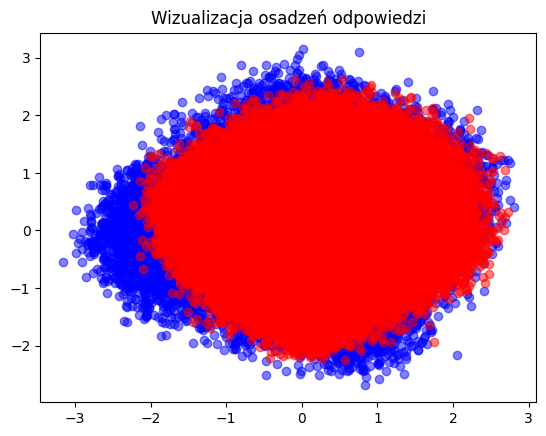

In [110]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings_a = pca.fit_transform(answer_embeddings.cpu().numpy())
reduced_embeddings_q = pca.fit_transform(question_embeddings.cpu().numpy())

plt.scatter(reduced_embeddings_a[:, 0], reduced_embeddings_a[:, 1], alpha=0.5, color="blue")
plt.scatter(reduced_embeddings_q[:, 0], reduced_embeddings_q[:, 1], alpha=0.5, color="red")

plt.title("Wizualizacja osadzeń odpowiedzi")
plt.show()


In [111]:
top_k = 5

In [112]:
for question in questions[:10]:
  question_embedding = model.encode(question, convert_to_tensor=True)
  similarity_scores = model.similarity(question_embedding, answer_embeddings)[0]
  scores, indices = torch.topk(similarity_scores, k=top_k)

  print("\nQuery:", question)
  print("Top 5 most similar sentences in corpus:")

  for score, idx in zip(scores, indices):
      print(answers[idx], f"(Score: {score:.4f})")



Query: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Top 5 most similar sentences in corpus:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. (Score: 21.6458)
The Gospel of Luke begins its account of Mary's life with the Annunciation, when the angel Gabriel appeared to her and announced her divine selection to be the mother 

In [113]:
# embeddings_dataset = Dataset.from_dict({'answers': answers, 'embeddings': answer_embeddings})
embeddings_dataset_faiss = Dataset.from_dict({'answers': answers, 'embeddings': answer_embeddings})
embeddings_dataset_faiss.add_faiss_index(column="embeddings")

  0%|          | 0/19 [00:00<?, ?it/s]

Dataset({
    features: ['answers', 'embeddings'],
    num_rows: 18891
})

In [114]:
def test_no_faiss_retriver(k=100):
    pos = []
    for question, question_embedding in tqdm(list(zip(questions, question_embeddings))):
        answer = labels[question]
        similarity_scores = model.similarity(question_embedding, answer_embeddings)[0]
        
        similarity_scores, idxs = torch.topk(similarity_scores, k=k)
        in_top = False
        for i, idx in enumerate(idxs):
            if answer == answers[idx]:
                pos.append(i)
                in_top = True
                break
        if not in_top:
            pos.append(k)

    return pos

idxs_no_faiss = test_no_faiss_retriver()

100%|██████████| 87599/87599 [01:14<00:00, 1168.52it/s]


In [115]:
def test_faiss_retriver(k=100):
    pos = []
    for question, question_embedding in tqdm(list(zip(questions, question_embeddings))):
        correct_answer = labels[question]

        scores, samples = embeddings_dataset_faiss.get_nearest_examples(
            "embeddings", question_embedding.cpu().numpy(), k=k
        )

        idx = k
        for i, answer in enumerate(samples['answers']):
            if correct_answer == answer:
                idx = i
                break
        pos.append(idx)

    return pos

idxs_faiss = test_faiss_retriver()

100%|██████████| 87599/87599 [58:42<00:00, 24.87it/s]  


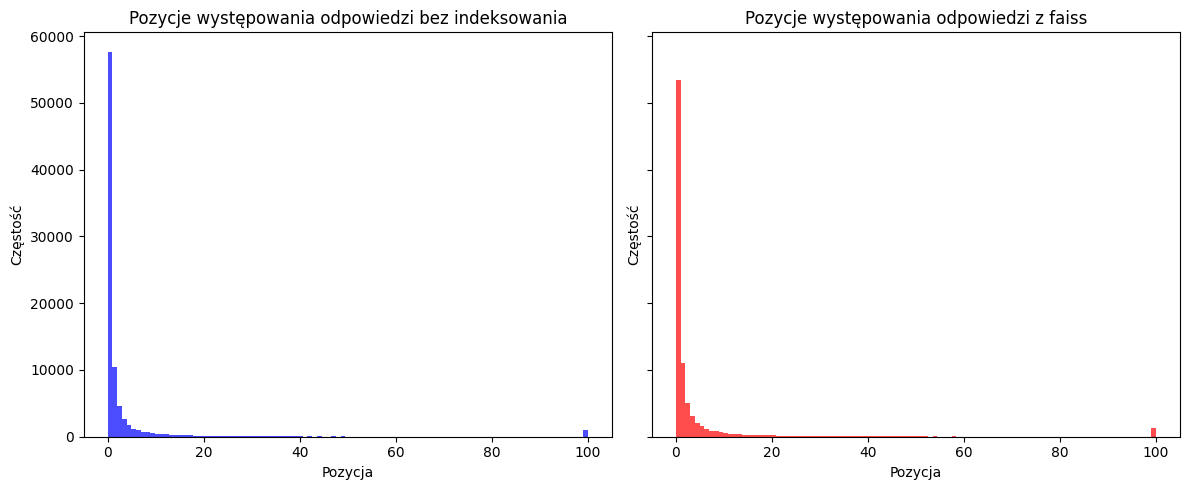

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].hist(idxs_no_faiss, bins=101, color='blue', alpha=0.7)
axes[0].set_title('Pozycje występowania odpowiedzi bez indeksowania')
axes[0].set_xlabel('Pozycja')
axes[0].set_ylabel('Częstość')

axes[1].hist(idxs_faiss, bins=101, color='red', alpha=0.7)
axes[1].set_title('Pozycje występowania odpowiedzi z faiss')
axes[1].set_xlabel('Pozycja')
axes[1].set_ylabel('Częstość')

plt.tight_layout()
plt.show()

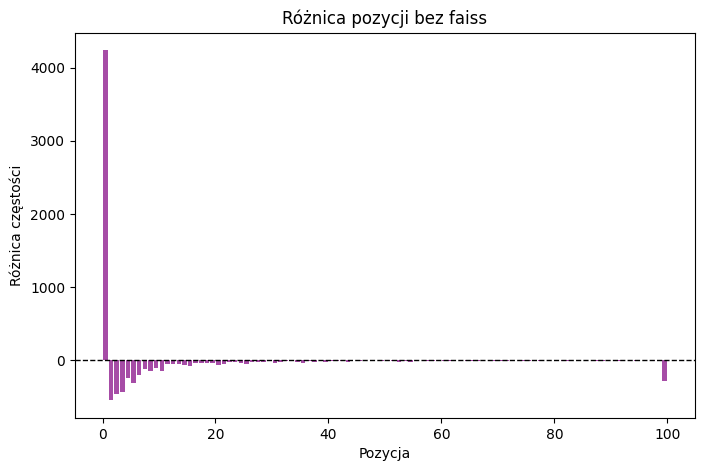

In [122]:
bins = np.linspace(0, 100, 101)
hist1, _ = np.histogram(idxs_no_faiss, bins=bins)
hist2, _ = np.histogram(idxs_faiss, bins=bins)

difference = hist1 - hist2

bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.figure(figsize=(8, 5))
plt.bar(bin_centers, difference, width=0.8 * (bins[1] - bins[0]), color='purple', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Różnica pozycji bez faiss')
plt.xlabel('Pozycja')
plt.ylabel('Różnica częstości')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].plot(range(1, 101), recalls, color='blue', linestyle='-', linewidth=2)
axes[0].set_.title("Wartość recall w zależności od k")
axes[0].set_xlabel('Pozycja')
axes[0].set_ylabel('Częstość')

axes[1].plot(range(1, 101), recalls, color='blue', linestyle='-', linewidth=2)
axes[1].set_.title("Wartość recall w zależności od k")
axes[1].set_xlabel('Pozycja')
axes[1].set_ylabel('Częstość')

plt.tight_layout()
plt.show()

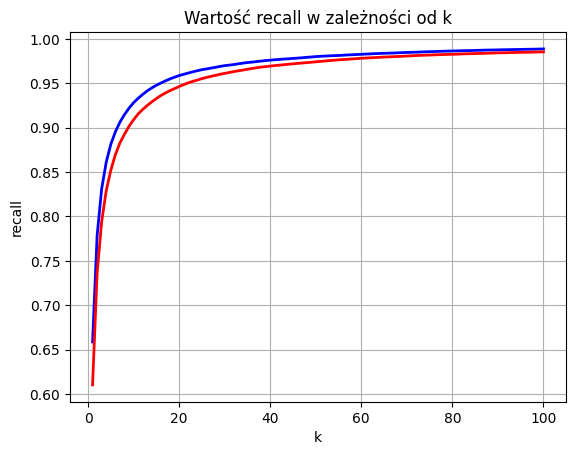

In [123]:
recalls_no_faiss = [sum(1 for x in idxs_no_faiss if x <= i) / len(questions) for i in range(100)]
recalls_faiss = [sum(1 for x in idxs_faiss if x <= i) / len(questions) for i in range(100)]

plt.plot(range(1, 101), recalls_no_faiss, color='blue', linestyle='-', linewidth=2, label='brak indeksowania')
plt.plot(range(1, 101), recalls_faiss, color='red', linestyle='-', linewidth=2, label='faiss')
plt.title("Wartość recall w zależności od k")
plt.xlabel("k")
plt.ylabel("recall")
plt.grid(True)
plt.show()

In [127]:
print(f'Bez indeksowania:\trecall@5 = {recalls_no_faiss[4]:.2f}\t\trecall@10 = {recalls_no_faiss[9]:.2f}\trecall@100 = {recalls_no_faiss[99]:.2f}')
print(f'Z faiss:\t\trecall@5 = {recalls_faiss[4]:.2f}\t\trecall@10 = {recalls_faiss[9]:.2f}\trecall@100 = {recalls_faiss[99]:.2f}')

Bez indeksowania:	recall@5 = 0.88		recall@10 = 0.93	recall@100 = 0.99
Z faiss:		recall@5 = 0.85		recall@10 = 0.91	recall@100 = 0.99


In [128]:
mrr_no_faiss = np.mean([1 / (idx + 1) for idx in idxs_no_faiss])
mrr_faiss = np.mean([1 / (idx + 1) for idx in idxs_faiss])

print('Mean Reciprocal Rank')
print(f'No indez: {mrr_no_faiss}')
print(f'Z faiss: {mrr_faiss}')

Mean Reciprocal Rank
No indez: 0.7571349812957545
Z faiss: 0.7175555305743269
